In [2]:
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
print(data_df.head(5))

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0           

In [3]:
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

vo_clf = VotingClassifier( estimators = [('LR',lr_clf),('KNN',knn_clf)], voting= 'soft')
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size = 0.2, random_state = 156)

vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print(accuracy_score(y_test, pred))

classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    print(accuracy_score(y_test, pred))

0.9473684210526315
0.9385964912280702
0.9385964912280702


C:\Users\KMC.KMC\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\KMC.KMC\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

In [4]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [10]:
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
print(accuracy_score(y_test, pred))

0.9195792331184255


In [12]:
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth' : [8, 16, 24],
    'min_samples_leaf' : [1,6,12],
    'min_samples_split' : [2,8, 16]
}
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(X_train, y_train)
print(grid_cv.best_params_)
print(grid_cv.best_score_)

{'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
0.9164853101196953


In [13]:
rf_clf1 = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 6, max_depth = 16, min_samples_split = 2, random_state = 0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print(accuracy_score(y_test, pred))

0.9260264675941635


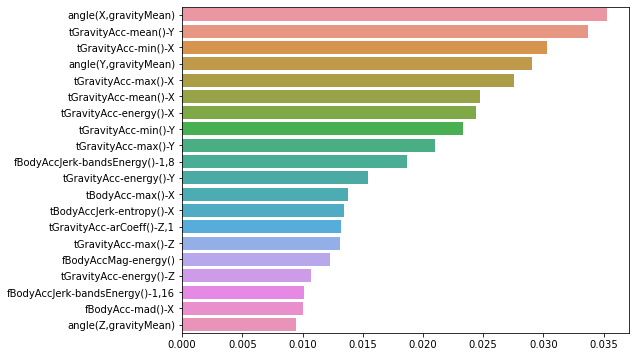

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (8,6))
sns.barplot(x= ftr_top20, y= ftr_top20.index)
plt.show()

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()
start_time = time.time()

In [18]:
import xgboost
print(xgboost.__version__)

1.5.0


In [19]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

In [20]:
cancer_df = pd.DataFrame(data = features, columns = dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [21]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [23]:
X_features = cancer_df.iloc[:,:-1]
y_labels = cancer_df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size = 0.2, random_state = 156)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size= 0.1, random_state = 156)

In [26]:
dtr = xgb.DMatrix(data = X_tr, label=y_tr)
dval = xgb.DMatrix(data = X_val, label = y_val)
dtest = xgb.DMatrix(data = X_test, label = y_test)

In [27]:
params = {
    'max_depth' : 3,
    'eta' : 0.05,
    'objective' : 'binary:logistic',
    'eval_metric': 'logloss'
}
num_rounds = 400

In [28]:
eval_list = [(dtr,'train'), (dval, 'eval')]
xgb_model = xgb.train(params = params, dtrain = dtr, num_boost_round = num_rounds, early_stopping_rounds = 50, evals = eval_list)

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52929
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31893	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

[170]	train-logloss:0.01312	eval-logloss:0.26133
[171]	train-logloss:0.01304	eval-logloss:0.26148
[172]	train-logloss:0.01297	eval-logloss:0.26157
[173]	train-logloss:0.01285	eval-logloss:0.26253
[174]	train-logloss:0.01278	eval-logloss:0.26229
[175]	train-logloss:0.01267	eval-logloss:0.26086
[176]	train-logloss:0.01258	eval-logloss:0.26103


In [31]:
import numpy as np
pred_probs = xgb_model.predict(dtest)
print(np.round(pred_probs[:10],3))

pred = [1 if x>0.5 else 0 for x in pred_probs]
print(pred[:10])

[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [33]:
get_clf_eval(y_test, pred, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9937


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

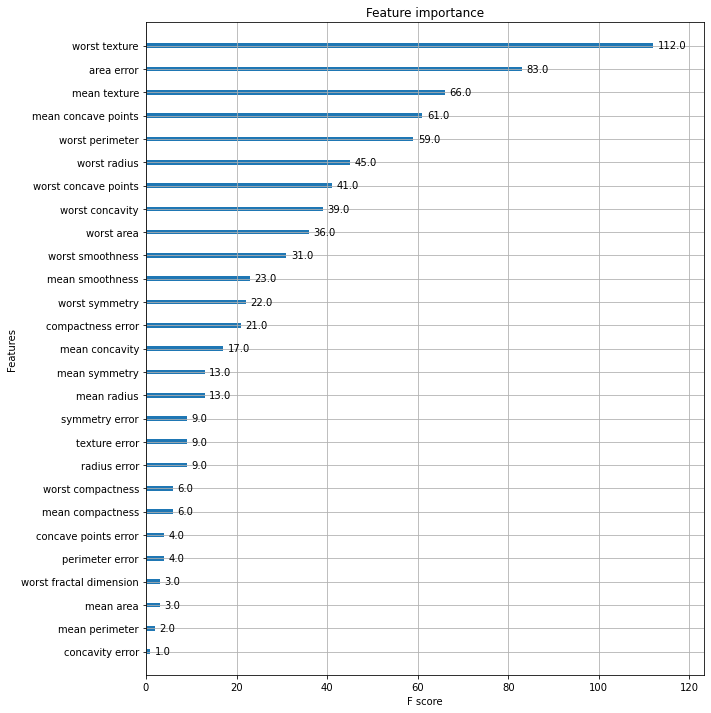

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(xgb_model, ax=ax)

In [37]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.05, max_depth = 3, eval_metric = 'logloss')
xgb_wrapper.fit(X_train, y_train, verbose = True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

In [38]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


In [42]:
xgb_wrapper = XGBClassifier(n_estimatores = 400, learning_rate = 0.05, max_depth = 3)
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 50, eval_metric = "logloss", eval_set = evals, verbose = True)
ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[01:28:42] WARNING: ..\src\learner.cc:576: 
Parameters: { "n_estimatores" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52929
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_

In [43]:
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

오차 행렬
[[34  3]
 [ 3 74]]
정확도: 0.9474, 정밀도: 0.9610, 재현율: 0.9610,    F1: 0.9610, AUC:0.9933


In [46]:
import lightgbm
print(lightgbm.__version__)

3.3.2


In [47]:
from hyperopt import hp

In [48]:
search_space = {'x': hp.quniform('x',-10,10,1), 'y': hp.quniform('y',-15,15,1)}

In [49]:
from hyperopt import STATUS_OK

def object_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y
    
    return retval

In [53]:
from hyperopt import fmin, tpe, Trials  

trial_val = Trials()

best_01 = fmin(fn=object_func, space = search_space, algo=tpe.suggest, max_evals = 5, trials = trial_val,
              rstate=np.random.default_rng(seed=0))
print(best_01)

100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 833.20trial/s, best loss: -224.0]
{'x': -4.0, 'y': 12.0}


In [54]:
best_02 = fmin(fn=object_func, space = search_space, algo=tpe.suggest, max_evals = 20, trials = trial_val,
              rstate=np.random.default_rng(seed=0))
print(best_02)

100%|██████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1499.68trial/s, best loss: -296.0]
{'x': 2.0, 'y': 15.0}


In [56]:
dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data = dataset.data, columns = dataset.feature_names)
cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state = 156)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 156)

In [57]:
xgb_search_space = {
    'max_depth': hp.quniform('max_depth',5,20,1),
    'min_child_weight': hp.quniform('min_child_weight',1,2,1),
    'learning_rate' : hp.uniform('learning_rate',0.01,0.2),
    'colsample_bytree':hp.uniform('colsample_bytree',0.5,1)
}

In [66]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators = 100, max_depth = int(search_space['max_depth'],
                            min_child_weight = int(search_space['min_child_weight']), learning_rate = search_space['learning_rate'],
                            colsample_bytree = search_space['colsample_bytree'], eval_metric = 'logloss'))
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring = 'accuracy', cv=3)
    return {'loss': -1*np.mean(accuracy), 'status': STATUS_OK}

In [67]:
from hyperopt import fmin, tpe, Trials
trail_val = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)

 40%|█████████████████████████████▌                                            | 20/50 [00:00<?, ?trial/s, best loss=?]


KeyError: 'colsample_bytree'